In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [70]:
import pandas as pd
import numpy as np
from keras.layers import Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [3]:
data = pd.read_json('/Users/yuhanqi/Desktop/Master Thesis/code/data/sample_1000000_2005_2018_cleaned.json')

In [4]:
data['stars_reduce'] = data['stars']-1

In [5]:
data.head(1)

,index,text,stars,cleaned_text,stars_reduce
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...,4


In [6]:
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [7]:
X_train, X_test,Y_train, Y_test = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [9]:
#A function to read the contents of the GloVe Vector file
#Returns a dictionary that maps the words to their respective word embeddings
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [10]:
word_to_vec_map = read_glove_vector('/Users/yuhanqi/Desktop/Master Thesis/code/model/glove.twitter.27B/glove.twitter.27B.50d.txt')

In [31]:
maxLen = 300
vocab_len = len(words_to_index)+1
embed_vector_len = word_to_vec_map['moon'].shape[0]

In [32]:
vocab_len

172192

In [33]:
emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [34]:
def conv1d_model(input_shape):
  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = Conv1D(256,3,activation='relu')(embeddings)
  X = Dropout(0.6)(X)
    
  X = Conv1D(128,3,activation='relu')(X)
  X = Dropout(0.6)(X)

  X = GlobalMaxPooling1D()(X)

  X = Dense(128, activation='relu')(X)
  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [35]:
model = conv1d_model((maxLen,))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 50)           8609600   
                                                                 
 conv1d_10 (Conv1D)          (None, 298, 256)          38656     
                                                                 
 dropout_5 (Dropout)         (None, 298, 256)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 296, 128)          98432     
                                                                 
 dropout_6 (Dropout)         (None, 296, 128)          0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0   

In [36]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(800000, 300)


In [37]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='loss', patience=2)
epochs = 10
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[callback])

Epoch 1/10
12500/12500 [==============================] - 913s 73ms/step - loss: 1.3521 - accuracy: 0.4313
Epoch 2/10
12500/12500 [==============================] - 918s 73ms/step - loss: 1.1368 - accuracy: 0.5034
Epoch 3/10
12500/12500 [==============================] - 1123s 90ms/step - loss: 1.0711 - accuracy: 0.5317
Epoch 4/10
12500/12500 [==============================] - 1038s 83ms/step - loss: 1.0305 - accuracy: 0.5501
Epoch 5/10
12500/12500 [==============================] - 924s 74ms/step - loss: 1.0033 - accuracy: 0.5622
Epoch 6/10
12500/12500 [==============================] - 918s 73ms/step - loss: 0.9813 - accuracy: 0.5722
Epoch 7/10
12500/12500 [==============================] - 922s 74ms/step - loss: 0.9648 - accuracy: 0.5799
Epoch 8/10
12500/12500 [==============================] - 1039s 83ms/step - loss: 0.9518 - accuracy: 0.5837
Epoch 9/10
12500/12500 [==============================] - 965s 77ms/step - loss: 0.9409 - accuracy: 0.5889
Epoch 10/10
12500/12500 [=========

In [40]:
model.evaluate(X_test_indices, Y_test)

6250/6250 [==============================] - 95s 15ms/step - loss: 1.0207 - accuracy: 0.6083


[1.0207228660583496, 0.6082850098609924]

dict_keys(['loss', 'accuracy'])


Text(0.5, 1.0, 'Accuracy')

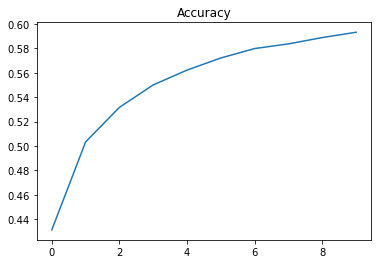

In [54]:
#plot accuracy
print(history.history.keys())
# plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
# plt.plot(range(epochs), history.history['val_accuracy'])
# plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

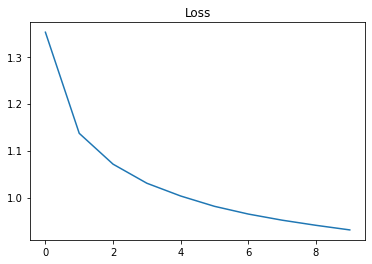

In [55]:
#plot loss
#plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['loss'])
# plt.plot(range(epochs), history.history['val_loss'])
# plt.legend(['training_acc', 'validation_acc'])
plt.title('Loss')

In [47]:
preds = model.predict(X_test_indices)

In [48]:
preds

array([[0.07421052, 0.08985864, 0.16058351, 0.30517513, 0.3701722 ],
       [0.02928997, 0.02969958, 0.08206831, 0.28447753, 0.5744646 ],
       [0.21325055, 0.26101482, 0.26162225, 0.17292382, 0.09118856],
       ...,
       [0.00949187, 0.01589574, 0.06133924, 0.30453652, 0.60873663],
       [0.0933654 , 0.15794894, 0.27011013, 0.3035784 , 0.17499715],
       [0.1412901 , 0.22571975, 0.26498038, 0.21887243, 0.14913738]],
      dtype=float32)

In [39]:
model.save('/Users/yuhanqi/Desktop/Master Thesis/code/model/glove_cnn_2015_2018_1000000')

2022-05-30 23:45:58.785133: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/yuhanqi/Desktop/Master Thesis/code/model/glove_cnn_2015_2018_1000000/assets


In [49]:
loaded_model = keras.models.load_model('/Users/yuhanqi/Desktop/Master Thesis/code/model/glove_cnn_2015_2018_1000000')

In [50]:
# Let's check:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [51]:
loaded_preds = loaded_model.predict(X_test_indices)

In [75]:
star_pred = np.argmax(loaded_preds, axis=1)+1